In [1]:
import glob
import os
import warnings
warnings.filterwarnings("ignore")

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import xarray as xr

import gpflow
from esem import gp_model
from scipy import stats
from sklearn.metrics import mean_squared_error

from SALib.sample import fast_sampler
from SALib.analyze import fast

2022-12-22 11:37:46.880688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 11:37:47.027026: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-22 11:37:47.843137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [2]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,var):
    return norm_var*np.array(max(var)-min(var)) + np.array(min(var))

### Explore parameter senstivity 

- Use Gaussian process emulator to explore one-at-a-time parameter influence
    - ESEm: https://esem.readthedocs.io/en/latest/index.html
    - Introduction to GP emulation: https://distill.pub/2019/visual-exploration-gaussian-processes/
    - 



- Determine relative parameter influence using Fourier Amplitude Sensitivity Test (FAST) analysis. 
    - SALib library: https://salib.readthedocs.io/en/latest/api.html#fast-fourier-amplitude-sensitivity-test
    - Saltelli, 1999 doi:10.1080/00401706.1999.10485594.

In [3]:
#read in LAI metrics
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')

In [4]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [5]:
### Global mean annual mean LAI (2005-2014)

In [6]:
# select target variable and divide LHC dataset into training and testing subsets
var = 'TLAI_global_avg_2010'
n_test = 50 # number of ensemble members to test emulator
Y = ds[var][1:].values # target variable excluding default model [0]
default = ds[var][0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [7]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(5,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32
kernel

2022-12-22 11:37:50.792428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-22 11:37:50.792472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc19): /proc/driver/nvidia/version does not exist
2022-12-22 11:37:50.795055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,"(32,)",float64,"[1., 1., 1...."


In [8]:
# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

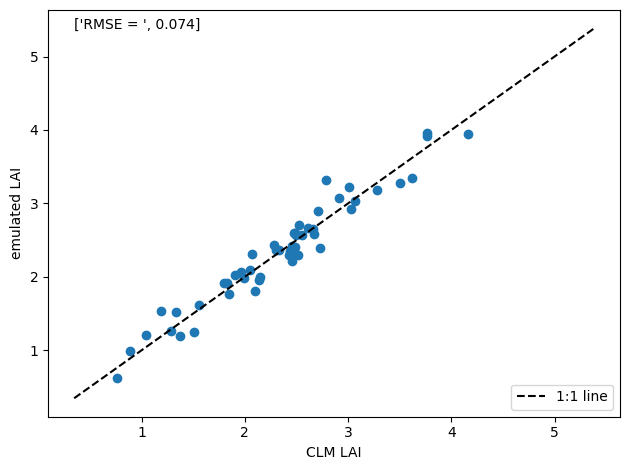

In [10]:
# plot predicted values
rms = mean_squared_error(normalize(y_test), normalize(y_pred), squared=False)

plt.scatter(y_test,y_pred)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_train),max(y_train),['RMSE = ',np.round(rms,3)])
plt.xlabel('CLM LAI')
plt.ylabel('emulated LAI')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../figs/param_sens/val_original_lin+m32-1_GM-AM_TLAI.png',dpi=200)

In [11]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

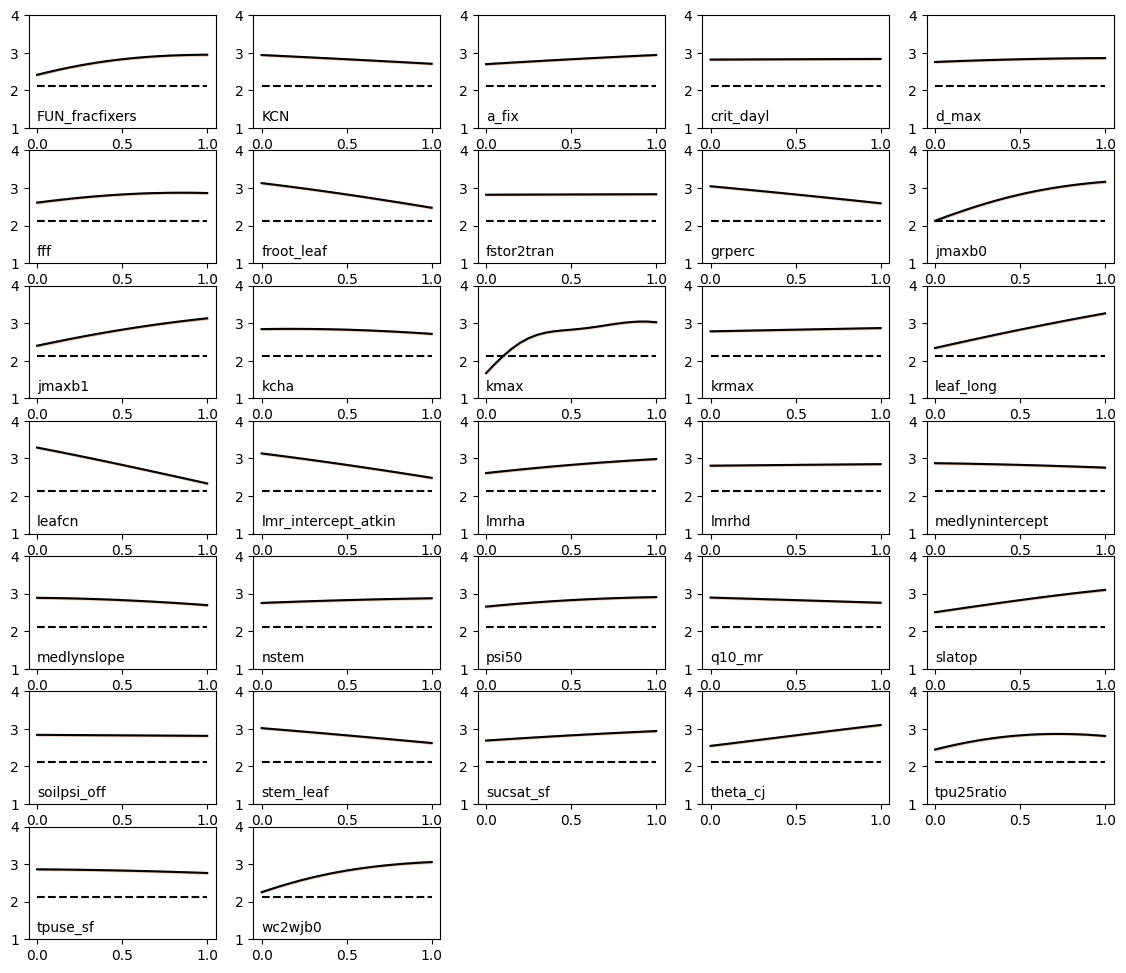

In [12]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,1.2,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([1,4])
    
plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_TLAI.png',dpi=200)

In [13]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}
problem

{'names': Index(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
        'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha',
        'kmax', 'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin', 'lmrha',
        'lmrhd', 'medlynintercept', 'medlynslope', 'nstem', 'psi50', 'q10_mr',
        'slatop', 'soilpsi_off', 'stem_leaf', 'sucsat_sf', 'theta_cj',
        'tpu25ratio', 'tpuse_sf', 'wc2wjb0'],
       dtype='object'),
 'num_vars': 32,
 'bounds': [[0, 1]]}

In [14]:
sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
lai_sens = pd.DataFrame.from_dict(FAST)
lai_sens.index = lai_sens.names
df_sens = lai_sens.sort_values(by=['S1'],ascending=False)

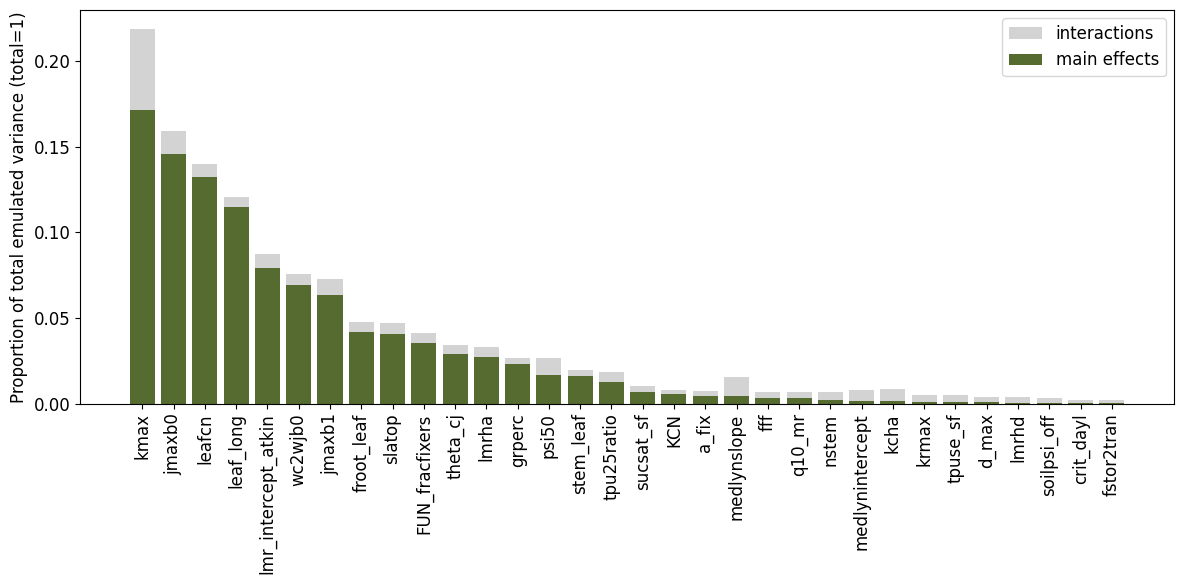

In [15]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_TLAI.png',dpi=200)

### Repeat for other metrics in ds
## Trend in global mean annual mean LAI (1975-2014)

In [16]:
# select target variable and divide LHC dataset into training and testing subsets
var = 'TLAI_global_trend_1975'
n_test = 50 # number of ensemble members to test emulator
Y = ds[var][1:].values # target variable excluding default model [0]
Y_norm = normalize(Y)
default = ds[var][0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y_norm[:n_test], Y_norm[n_test:]

# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
kernel = kernel_linear + kernel_RBF

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

Root Mean Square Error =  0.06350057814218579


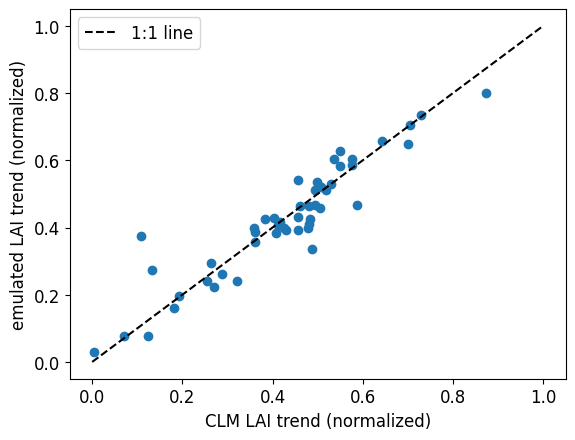

In [17]:
# Predict test points with emulator and plot
y_pred, y_pred_var = emulator.predict(X_test.values)

rms = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Square Error = ', rms)

plt.scatter(y_test,y_pred)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
plt.xlabel('CLM LAI trend (normalized)')
plt.ylabel('emulated LAI trend (normalized)')
plt.legend()

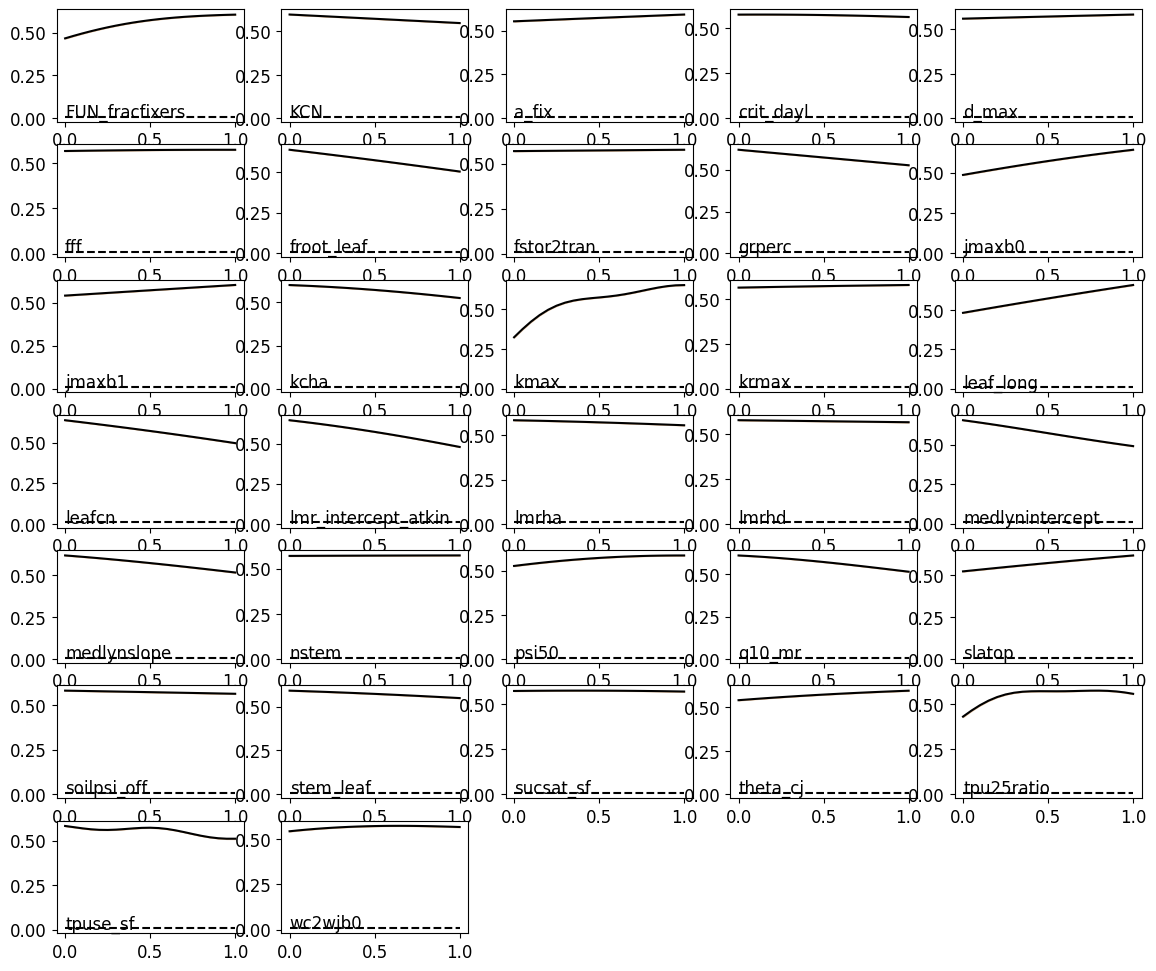

In [18]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.0055,p)
    plt.plot([0,1],[default, default],'--',c='k')
    #ax.set_ylim([0.005,0.01])
    
#plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_TLAI_trend_.png',dpi=200)

In [19]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
lai_trend_sens = pd.DataFrame.from_dict(FAST)
lai_trend_sens.index = lai_trend_sens.names
df_sens = lai_trend_sens.sort_values(by=['S1'],ascending=False)

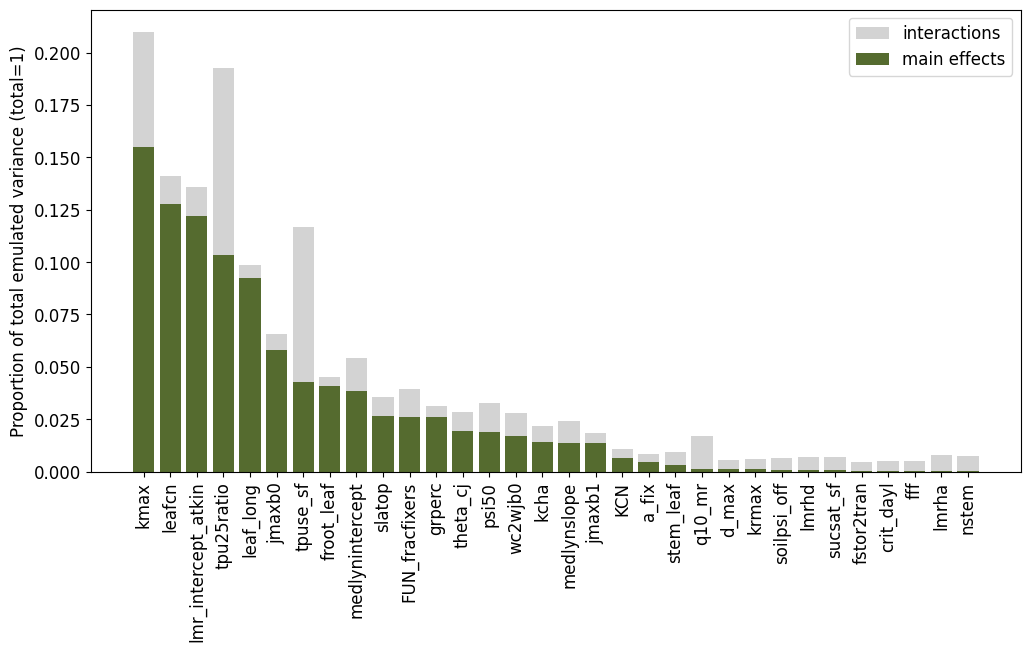

In [20]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_TLAI_trend.png',dpi=200)

## Biome level LAI

Root Mean Square Error =  0.04124629871594274


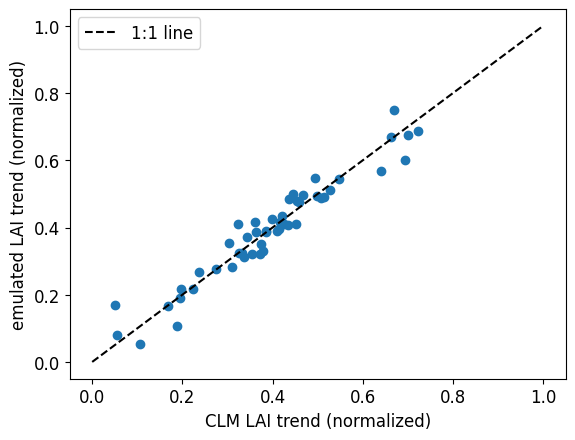

Root Mean Square Error =  0.04321855825725758


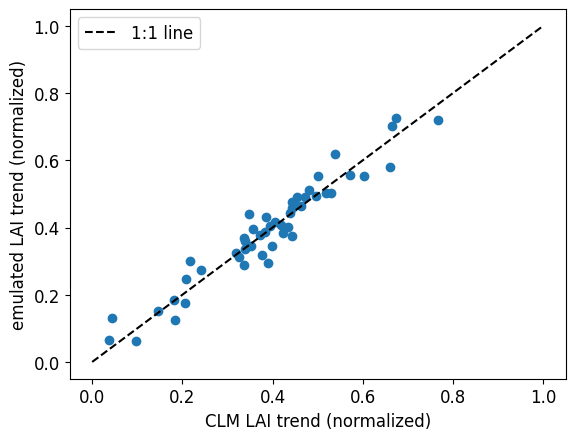

Root Mean Square Error =  0.07732709184576846


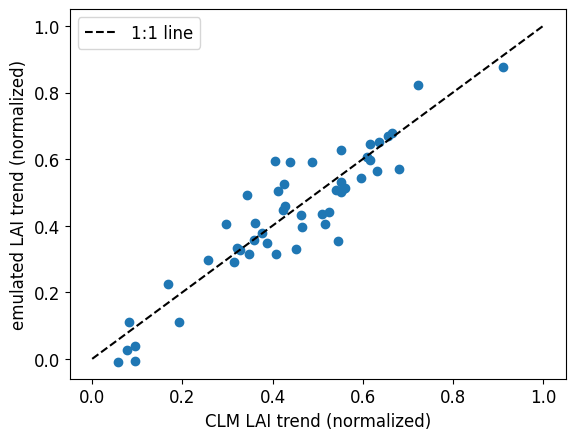

Root Mean Square Error =  0.04714745505377706


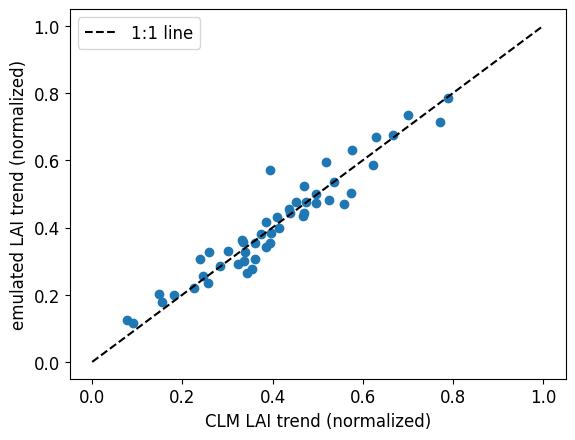

Root Mean Square Error =  0.0416994848194934


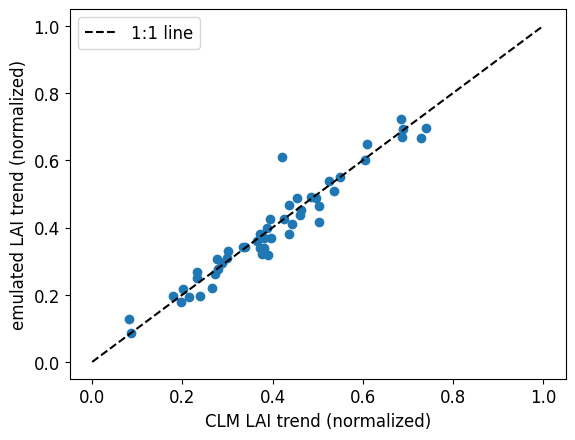

Root Mean Square Error =  0.059620952421167966


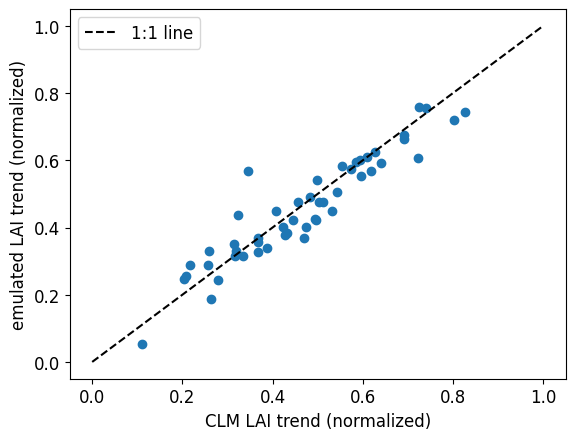

Root Mean Square Error =  0.059273045138143736


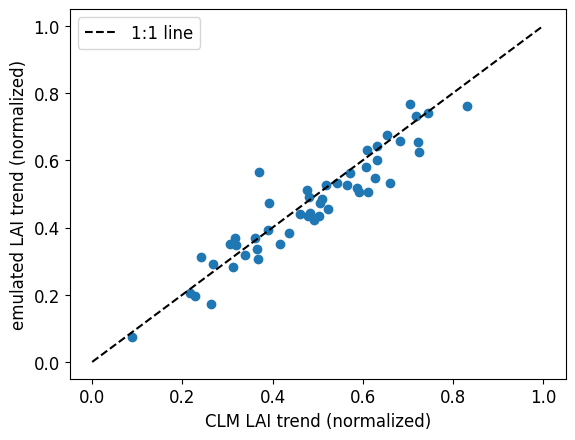

Root Mean Square Error =  0.051881761161087205


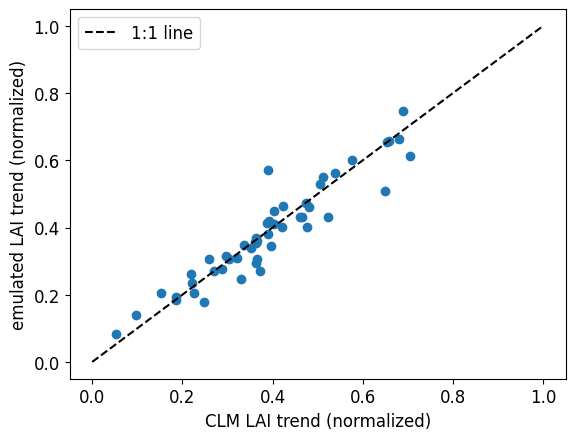

Root Mean Square Error =  0.04790007503767665


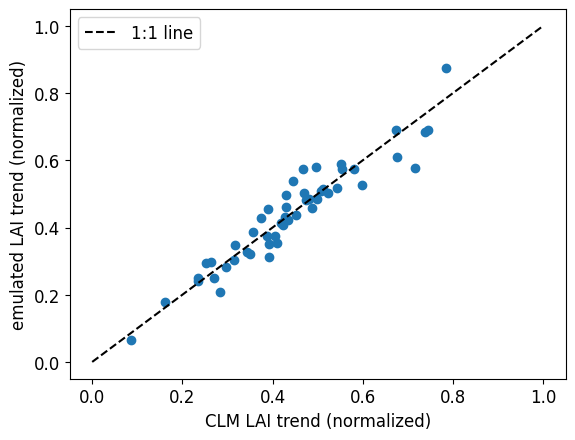

In [21]:
# select target variable and divide LHC dataset into training and testing subsets

biome_sens = np.empty([10,32])

for b in range(1,10):
    var = ds['TLAI_biome_avg_2010'].sel(biome=b)
    n_test = 50 # number of ensemble members to test emulator
    Y = var[1:].values # target variable excluding default model [0]
    Y_norm = normalize(Y)
    default = var[0].values # default model value

    X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
    y_test, y_train = Y_norm[:n_test], Y_norm[n_test:]

    # define kernal
    kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
    kernel_matern32 = gpflow.kernels.Matern32(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
    kernel = kernel_linear + kernel_matern32

    # define emulator model and train
    emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
    emulator.train()
    
    # Predict test points with emulator and plot
    y_pred, y_pred_var = emulator.predict(X_test.values)

    rms = mean_squared_error(y_test, y_pred, squared=False)
    print('Root Mean Square Error = ', rms)

    plt.scatter(y_test,y_pred)
    plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
    plt.xlabel('CLM LAI trend (normalized)')
    plt.ylabel('emulated LAI trend (normalized)')
    plt.legend()
    plt.show()
    
    # fourier amplitude sensitivity test
    problem = {
        'names': ppe_params.columns,
        'num_vars': num_params,
        'bounds': [[0, 1]],
    }

    sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
    Y, _ = emulator.predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    df_sens = pd.DataFrame.from_dict(FAST)
    df_sens.index = df_sens.names
    biome_sens[b,:] = df_sens['S1']

### Heatmap

In [24]:
sensitivity = [lai_sens['S1'],lai_trend_sens['S1'],biome_sens[1],biome_sens[2],biome_sens[3],
               biome_sens[4],biome_sens[5],biome_sens[6],biome_sens[7],biome_sens[8],biome_sens[9]]

In [25]:
params = ['jmaxb0', 'jmaxb1', 'leafcn', 'wc2wjb0', 'medlynint', 'medlynslope', 'kcha', 'tpu25ratio', 'tpuse_sf', 'theta_cj',
          'kmax', 'krmax', 'psi50', 'fstor2tran','crit_dayl', 'froot_leaf', 'nstem', 'sla_top','leaf_long', 'stem_leaf', 'soil_psioff',
          'grperc', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'q10_mr', 'FUN_fracfixers', 'KCN', 'a_fix', 'fff', 'd_max', 'sucsat_sf']

var_names = ['global LAI','global LAI trend','tropical rainforest','tropical seasonal forest','subtropical desert','temperate rainforest','temperate seasonal forest','woodland/shrubland','temperate grassland','boreal forest','tundra']

df_sens = pd.DataFrame(columns = var_names)

for ii in range(len(sensitivity)):
    sens = sensitivity[ii]
    Y = [26,27,28,14,30,29,15,13,21,0,1,6,10,11,18,2,22,23,24,4,5,16,12,25,17,20,19,31,9,7,8,3]

    df_sens[var_names[ii]] = [x for _,x in sorted(zip(Y,sens))]

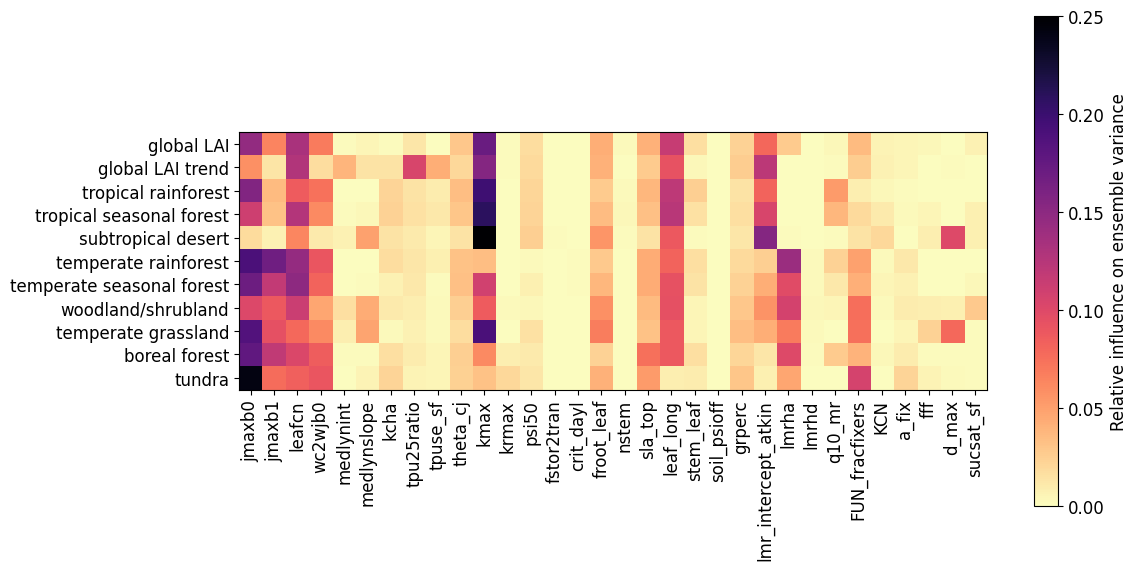

In [26]:
# heatmap of all global mean variables
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.subplot(1,1,1)
im = ax.imshow(df_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.25)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative influence on ensemble variance")
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_LAI_biomes_heatmap.png',dpi=200)